# Arbitrage Strategy Based on Book-to-Market

This notebook implements an arbitrage model based on the spread between accounting value (book value) and market value of major listed companies.
Enhancements include:
- Sector neutrality
- Transaction cost adjustments
- Combined value signals (Book-to-Market and Free Cash Flow Yield)
- Quality filtering (positive earnings, low accruals)

## Theoretical Framework

Let:
- $P_{i,t}$ = Price of stock *i* at time *t*
- $BVPS_{i,t}$ = Book Value per Share
- $MV_{i,t} = P_{i,t} \times Shares$
- $BV_{i,t} = BVPS_{i,t} \times Shares$

### Value Signal:
We consider book value to market capitalization ratio: how much accounting value is paid for by the market
$$
BTM_{i,t} = \frac{BV_{i,t}}{MV_{i,t}}
$$

### FCF Yield:
$$
FCFY_{i,t} = \frac{FCF_{i,t}}{MV_{i,t}}
$$

### Composite Signal (Z-Score):
$$
Z_{i,t} = \frac{(Signal_{i,t} - \mu_t)}{\sigma_t}
$$
Where $Signal_{i,t}$ combines BTM and FCFY, and $\mu_t$, $\sigma_t$ are cross-sectional mean and std.

We go **long** on stocks with low Z and **short** on high Z, adjusted for sector neutrality.

Should switch to dynamic book value calculation.

In [ ]:
# Requirements and setup for the project
%pip install -r ./requirements.txt
!mkdir -p ./data
!if [ ! -f ./.env ]; then echo "Please create a .env file with your ALPHA_VANTAGE_API_KEY."; fi

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import date
import os

from utils import get_fundamentals, load_fundamentals
from utils import compute_book_value_per_share, next_quarter
from utils import register_traffic_magic

register_traffic_magic()

In [ ]:
%%nettraffic

# CONFIG FOR AV + FETCH NEW DATA
# Ideally, only run a few times since key usage is limited
# List of ticker runs already executed locally:
# TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'META', 'AMZN', 'GTLB']
# TICKERS = ['TSLA', 'AI',   'AEO',   'BUD',  'F']
# TICKERS = ['ORCL', 'V',    'MA',    'UNH',  'NVDA', 'GOOG']
# TICKERS = ['AVGO', 'JPM',  'WMT',   'LLY',  'NFLX']
# TICKERS = ['XOM', 'PLTR', 'COST', 'JNJ', 'HD', 'PG']
# TICKERS = ['ABBV', 'BAC', 'CVX', 'KO', 'GE', 'CSCO']

# void : '1MC', 'KER', 'BRK.B'

TICKERS = []

function_map = {'b': 'BALANCE_SHEET', 'i': 'INCOME_STATEMENT', 'c': 'CASH_FLOW'}
fundamentals = {} # Comment this line to continue data fetching if connection resets

for ticker in TICKERS:
    overview = get_fundamentals(ticker, function='o')
    pd.DataFrame([overview]).to_csv(f'./data/archive/overview_{ticker}.csv', index=False)
    fundamentals[(ticker, 'current', 'OVERVIEW')] = overview

    for function in ['b', 'i', 'c']:
        reports = get_fundamentals(ticker, function=function)
        pd.DataFrame(reports).to_csv(f'./data/archive/{function}_{ticker}.csv', index=False)
        fundamentals.update({(ticker, report['fiscalDateEnding'], function_map[function]): report for report in reports})

# Convert the fundamentals dictionary to a DataFrame
fundamentals = {k: v for k, v in fundamentals.items() if v is not None}
df = pd.DataFrame(fundamentals).T
df.index.names = ['ticker', 'fiscalDateEnding', 'statementType']
df.drop(columns=['Symbol', 'fiscalDateEnding', 'statementType', 'index'], errors='ignore', inplace=True)
df.drop(columns=df.filter(regex=r"^Unnamed").columns, inplace=True, errors="ignore")
df.reset_index(inplace=True)

# Save data
os.makedirs(f'data/{date.today().isoformat()}', exist_ok=True)
df = load_fundamentals(df) # concat with previous data
df.to_csv(f'./data/{date.today().isoformat()}/fundamentals_{date.today().isoformat()}.csv')
# Save attributes
pd.DataFrame({'Attributes': df.columns.tolist()}).to_csv(f'./data/{date.today().isoformat()}/attributes_{date.today().isoformat()}.csv', index=False)

df = None  # Clear memory

2.96 MB inviati; 17.99 MB ricevuti.


In [4]:
# Prepare attributes + Check if same metrics are present in different statements
# Net Income appears in both income statement and cash flow statement; not always same values
b = pd.read_csv('./data/archive/b_AAPL.csv', index_col='fiscalDateEnding', parse_dates=True)
bc = b.columns.to_list()
i = pd.read_csv('./data/archive/i_AAPL.csv', index_col='fiscalDateEnding', parse_dates=True)
ic = i.columns.to_list()
c = pd.read_csv('./data/archive/c_AAPL.csv', index_col='fiscalDateEnding', parse_dates=True)
cc = c.columns.to_list()
o = pd.read_csv('./data/archive/overview_AAPL.csv', parse_dates=True)
oc = o.columns.to_list()

#print('Balance Sheet & Overview:', set(bc) & set(oc))
#print('Income & Overview:', set(ic) & set(oc))
#print('Cash Flow & Overview:', set(cc) & set(oc))
print('Balance Sheet & Income:', set(bc) & set(ic))
print('Balance Sheet & Cash Flow:', set(bc) & set(cc))
print('Income & Cash Flow:', set(ic) & set(cc))
# print(i[['netIncome']].iloc[-3:], c[['netIncome']].iloc[-3:])

Balance Sheet & Income: {'reportedCurrency'}
Balance Sheet & Cash Flow: {'reportedCurrency'}
Income & Cash Flow: {'netIncome', 'reportedCurrency'}


In [5]:
# Load the latest file
fundamentals = load_fundamentals()

# Remove rows with NaN values in all columns
fundamentals = fundamentals.dropna(how='all')

# Convert the DataFrame to numeric columns that start with a digit
#fundamentals = fundamentals.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.astype(str).str.contains(r'^\d', na=False).any() else x)
fundamentals = fundamentals.pivot_table(index=['ticker', 'fiscalDateEnding'], columns='statementType', values=bc + ic + cc + [col for col in oc if col not in ['Symbol']], aggfunc='first')
fundamentals.columns = fundamentals.columns.swaplevel(0, 1)
fundamentals.reset_index(inplace=True)
fundamentals = fundamentals.set_index(['ticker', 'fiscalDateEnding'])

# Filter out companies with negative EPS or profit margin
# We need keep any line with tickers s.t. its ('OVERVIEW','DilutedEPSTTM') column is > 0:
viable_tickers = fundamentals.where(
    (fundamentals['OVERVIEW']['DilutedEPSTTM'] > 0) & (fundamentals['OVERVIEW']['ProfitMargin'] > 0)
).index.get_level_values('ticker').unique()

fundamentals = fundamentals[fundamentals.index.get_level_values('ticker').isin(viable_tickers)]
# Calculate Book value per Share
fundamentals = compute_book_value_per_share(fundamentals)
fundamentals.head()

statementType                      OVERVIEW                                \
                        200DayMovingAverage 50DayMovingAverage 52WeekHigh   
ticker fiscalDateEnding                                                     
AAPL   2005-03-31                       NaN                NaN        NaN   
       2005-06-30                       NaN                NaN        NaN   
       2005-09-30                       NaN                NaN        NaN   
       2005-12-31                       NaN                NaN        NaN   
       2006-03-31                       NaN                NaN        NaN   

statementType                                                                 \
                        52WeekLow Address AnalystRatingBuy AnalystRatingHold   
ticker fiscalDateEnding                                                        
AAPL   2005-03-31             NaN     NaN              NaN               NaN   
       2005-06-30             NaN     NaN              NaN               NaN   
       2005-09-30             NaN     NaN              NaN               NaN   
       2005-12-31             NaN     NaN              NaN               NaN   
       2006-03-31             NaN     NaN              NaN               NaN   

statementType                                                     \
                        AnalystRatingSell AnalystRatingStrongBuy   
ticker fiscalDateEnding                                            
AAPL   2005-03-31                     NaN                    NaN   
       2005-06-30                     NaN                    NaN   
       2005-09-30                     NaN                    NaN   
       2005-12-31                     NaN                    NaN   
       2006-03-31                     NaN                    NaN   

statementType                                    ... BALANCE_SHEET  \
                        AnalystRatingStrongSell  ...   totalAssets   
ticker fiscalDateEnding                          ...                 
AAPL   2005-03-31                           NaN  ...  1.011100e+10   
       2005-06-30                           NaN  ...  1.048800e+10   
       2005-09-30                           NaN  ...  1.155100e+10   
       2005-12-31                           NaN  ...  1.418100e+10   
       2006-03-31                           NaN  ...  1.391100e+10   

statementType                                                       \
                        totalCurrentAssets totalCurrentLiabilities   
ticker fiscalDateEnding                                              
AAPL   2005-03-31             8.710000e+09            3.352000e+09   
       2005-06-30             9.042000e+09            3.123000e+09   
       2005-09-30             9.969000e+09            3.484000e+09   
       2005-12-31             1.169100e+10            5.060000e+09   
       2006-03-31             1.073000e+10            4.456000e+09   

statementType                                                   \
                        totalLiabilities totalNonCurrentAssets   
ticker fiscalDateEnding                                          
AAPL   2005-03-31           3.725000e+09          1.104000e+09   
       2005-06-30           3.667000e+09          1.112000e+09   
       2005-09-30           4.085000e+09          1.251000e+09   
       2005-12-31           5.801000e+09          2.019000e+09   
       2006-03-31           5.229000e+09          2.625000e+09   

statementType                                      INCOME_STATEMENT  \
                        totalNonCurrentLiabilities     totalRevenue   
ticker fiscalDateEnding                                               
AAPL   2005-03-31                      373000000.0     3.243000e+09   
       2005-06-30                      544000000.0     3.520000e+09   
       2005-09-30                      601000000.0     3.678000e+09   
       2005-12-31                      741000000.0     5.749000e+09   
       2006-03-31                      773000000.

In [ ]:
# set tickers to those contained in the full fundamentals loaded dataframe
TICKERS = fundamentals.index.get_level_values('ticker').unique().tolist()
START_DATE = '2005-06-30'
END_DATE = '2025-06-30'
TRANSACTION_COST = 0.01  # 1% per trade to be conservative

prices = yf.download(TICKERS, start=START_DATE, end=END_DATE)
close_prices = prices['Close']

book_values, fcf_yields, accruals, market_values, sectors, earnings = {}, {}, {}, {}, {}, {}

for ticker in TICKERS:
    
    firm_data = fundamentals.loc[ticker]
    sector = firm_data.loc[('current')][('OVERVIEW','Sector')]

    # Drop overview from firm_data
    firm_data = firm_data.drop(index='current', errors='ignore')

    # Get all fiscal periods except 'current' for this ticker
    dates = firm_data.index.get_level_values('fiscalDateEnding')
    dates = dates[dates != 'current']

    shares_outstanding = firm_data[('BALANCE_SHEET','commonStockSharesOutstanding')]
    shares_outstanding.index = pd.to_datetime(shares_outstanding.index)

    book_value_ps = firm_data[('BALANCE_SHEET','bookValuePerShare')]
    book_value_ps.index = pd.to_datetime(book_value_ps.index)

    total_assets = firm_data[('BALANCE_SHEET', 'totalAssets')]
    total_liabilities = firm_data[('BALANCE_SHEET', 'totalLiabilities')]

    # Earnings and cash flow
    earnings_series = firm_data[('INCOME_STATEMENT', 'netIncomeFromContinuingOperations')] # this or netIncome?
    op_cash = firm_data[('CASH_FLOW', 'operatingCashflow')]
    fcf = op_cash - firm_data[('CASH_FLOW', 'capitalExpenditures')]
    fcf.index = pd.to_datetime(fcf.index)

    # Ensure dates are datetime for alignment
    dates_dt = pd.to_datetime(dates)
    price_at_report = close_prices[ticker].reindex(dates_dt, method='ffill')
    price_at_report.index = pd.to_datetime(price_at_report.index)

    market_cap = shares_outstanding * price_at_report
    book_value = book_value_ps * shares_outstanding
    accrual = (earnings_series - op_cash) / total_assets
    fcf_yield = fcf / market_cap

    market_values[ticker] = market_cap
    book_values[ticker] = book_value
    fcf_yields[ticker] = fcf_yield
    earnings[ticker] = earnings_series
    accruals[ticker] = (earnings[ticker] - op_cash) / total_assets
    sectors[ticker] = sector

market_values = pd.DataFrame(market_values)
book_values = pd.DataFrame(book_values)
fcf_yields = pd.DataFrame.from_dict(fcf_yields)

btm = book_values / market_values
btm = btm.replace({np.inf: np.nan, -np.inf: np.nan}).dropna(how='all')

# BTM based signal
z_btm = btm.sub(btm.mean(axis=1), axis=0).div(btm.std(axis=1), axis=0).fillna(0)
# z_btm = z_btm.fillna(0) # No std-dev, so fill with 0? Perhaps distorts the signal

# FCFY based signal
z_fcf = fcf_yields.sub(fcf_yields.mean(axis=1), axis=0).div(fcf_yields.std(axis=1), axis=0).fillna(0)
#z_fcf = z_fcf.fillna(0) # No std-dev, so fill with 0

z_btm

/var/folders/j8/q1yzzyh9341fx__dgh644b400000gn/T/ipykernel_13940/1057859364.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(TICKERS, start=START_DATE, end=END_DATE)
[*********************100%***********************]  33 of 33 completed


,AAPL,ABBV,AEO,AI,AMZN,AVGO,BAC,BUD,COST,CSCO,...,NFLX,NVDA,ORCL,PG,PLTR,TSLA,UNH,V,WMT,XOM
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2005-06-30,-0.362026,0.000000,0.000000,0.000000,-0.876672,0.00000,0.055052,0.0,0.000000,0.000000,...,-0.561196,0.000000,0.000000,-0.395186,0.000000,0.000000,-0.485341,0.000000,0.000000,0.237533
2005-07-31,0.000000,0.000000,0.809477,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,-0.957944,...,0.000000,-0.975790,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.087081,0.000000
2005-08-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.707107,0.000000,...,0.000000,0.000000,-0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-09-30,-0.479537,0.000000,0.000000,0.000000,-0.837835,0.00000,0.115967,0.0,0.000000,0.000000,...,-0.641213,0.000000,0.000000,-0.533029,0.000000,0.000000,-0.475053,0.000000,0.000000,0.159482
2005-10-31,0.000000,0.000000,1.249930,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,-0.726379,...,0.000000,-1.174785,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.073052,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.707107,0.000000,...,0.000000,0.000000,-0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-03-31,-0.757541,-0.828205,0.000000,0.000000,-0.188576,0.00000,3.200301,0.0,0.000000,0.000000,...,-0.585672,0.000000,0.000000,-0.283202,-0.732856,-0.481163,0.126239,-0.602901,0.000000,1.418463
2025-04-30,0.000000,0.000000,2.321699,0.325024,0.000000,-0.51063,0.000000,0.0,0.000000,-0.015743,...,0.000000,-0.684328,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.348223,0.000000


### BtM-only based signal

In [60]:
z_sector_adj = z_btm.copy()
for date in z_btm.index:
    for sector in set(sectors.values()):
        tickers_in_sector = [ticker for ticker, sec in sectors.items() if sec == sector]
        if len(tickers_in_sector) >= 2:
            sector_mean = z_btm.loc[date, tickers_in_sector].mean()
            z_sector_adj.loc[date, tickers_in_sector] -= sector_mean

# Apply quality filters
quality = pd.Series(accruals).apply(lambda x: abs(x) < 0.25) & (earnings[ticker] > 0)
filtered_tickers = quality[quality].index

# for rebalancing every quarter
signal = z_sector_adj[filtered_tickers].shift(1)
signal = signal.reindex(close_prices.index).ffill()

# Assume we begin at an arbitrary date and never rebalance
DATE = '2011-06-30'
initial_signal = z_sector_adj.loc[DATE, filtered_tickers]
initial_signal = initial_signal / initial_signal.abs().sum() # normalize
signal_df = pd.DataFrame(index=close_prices.index, columns=initial_signal.index)
signal_df[:] = initial_signal.values

returns = close_prices[filtered_tickers].pct_change().loc[signal.index]
daily_return = (signal_df * returns).mean(axis=1)
daily_return = daily_return.loc[next_quarter(DATE):]
gross_return = (1 + daily_return).cumprod()
net_return = daily_return
net_return.loc[next_quarter(DATE)] -= TRANSACTION_COST # when th first return will be realized
net_cum_return = (1 + net_return).cumprod()

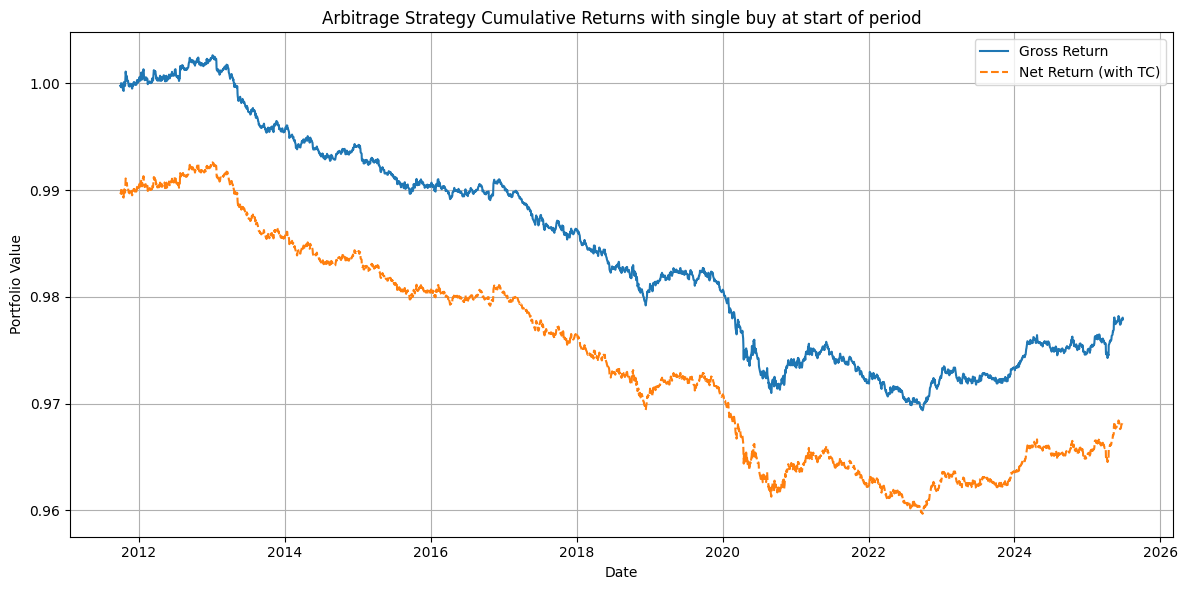

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(gross_return, label='Gross Return')
plt.plot(net_cum_return, label='Net Return (with TC)', linestyle='--')
plt.title("Arbitrage Strategy Cumulative Returns with single buy at start of period")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

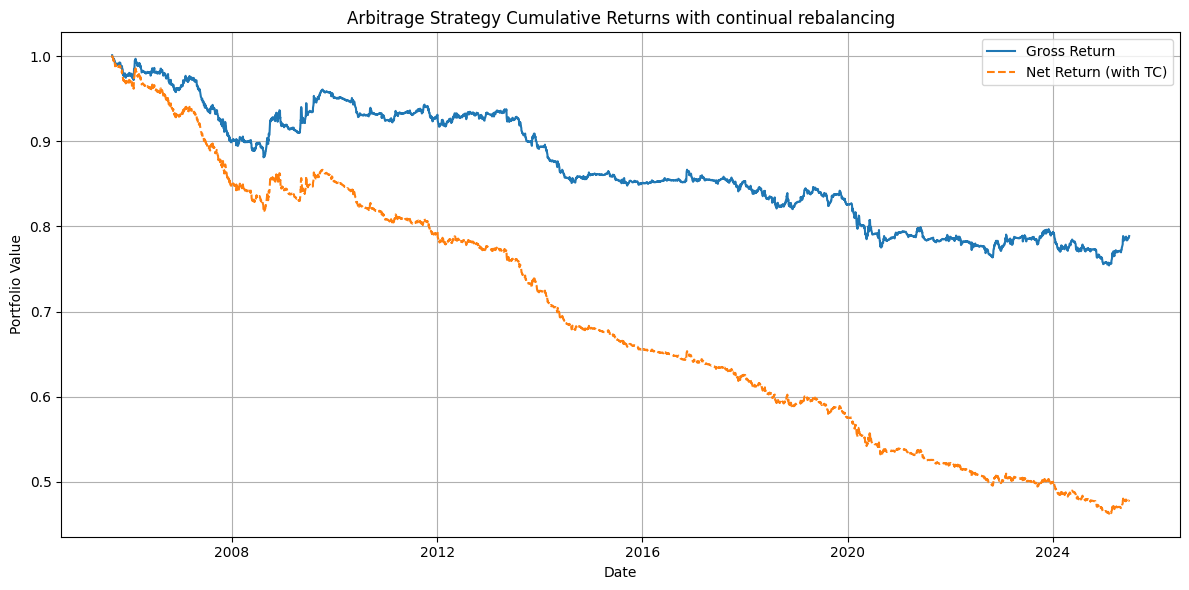

In [63]:
# If we want to rebalance continuously
TRANSACTION_COST = 0.0001  # 0.01% per trade, may be reasonable on large volumes?
DATE = '2011-06-30'
signal = z_sector_adj[filtered_tickers].shift(1)
signal = signal.reindex(close_prices.index).ffill()

returns = close_prices[filtered_tickers].pct_change().loc[signal.index] # net, i.e. 0.xx
daily_return = (signal * returns).mean(axis=1)
gross_return = (1 + daily_return).cumprod()
net_return = daily_return - TRANSACTION_COST
net_cum_return = (1 + net_return).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(gross_return, label='Gross Return')
plt.plot(net_cum_return, label='Net Return (with TC)', linestyle='--')
plt.title("Arbitrage Strategy Cumulative Returns with continual rebalancing")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### FCFY-only based signal

In [66]:
z_sector_adj = z_fcf.copy()
for date in z_fcf.index:
    for sector in set(sectors.values()):
        tickers_in_sector = [ticker for ticker, sec in sectors.items() if sec == sector]
        if len(tickers_in_sector) >= 2:
            sector_mean = z_fcf.loc[date, tickers_in_sector].mean()
            z_sector_adj.loc[date, tickers_in_sector] -= sector_mean

# Apply quality filters
quality = pd.Series(accruals).apply(lambda x: abs(x) < 0.25) & (earnings[ticker] > 0)
filtered_tickers = quality[quality].index

# for rebalancing every quarter
signal = z_sector_adj[filtered_tickers].shift(1)
signal = signal.reindex(close_prices.index).ffill()

# Assume we begin at an arbitrary date and never rebalance
DATE = '2011-06-30'
initial_signal = z_sector_adj.loc[DATE, filtered_tickers]
initial_signal = initial_signal / initial_signal.abs().sum() # normalize
signal_df = pd.DataFrame(index=close_prices.index, columns=initial_signal.index)
signal_df[:] = initial_signal.values

returns = close_prices[filtered_tickers].pct_change().loc[signal.index]
daily_return = (signal_df * returns).mean(axis=1)
daily_return = daily_return.loc[next_quarter(DATE):]
gross_return = (1 + daily_return).cumprod()
net_return = daily_return
net_return.loc[next_quarter(DATE)] -= TRANSACTION_COST # when the first return will be realized
net_cum_return = (1 + net_return).cumprod()

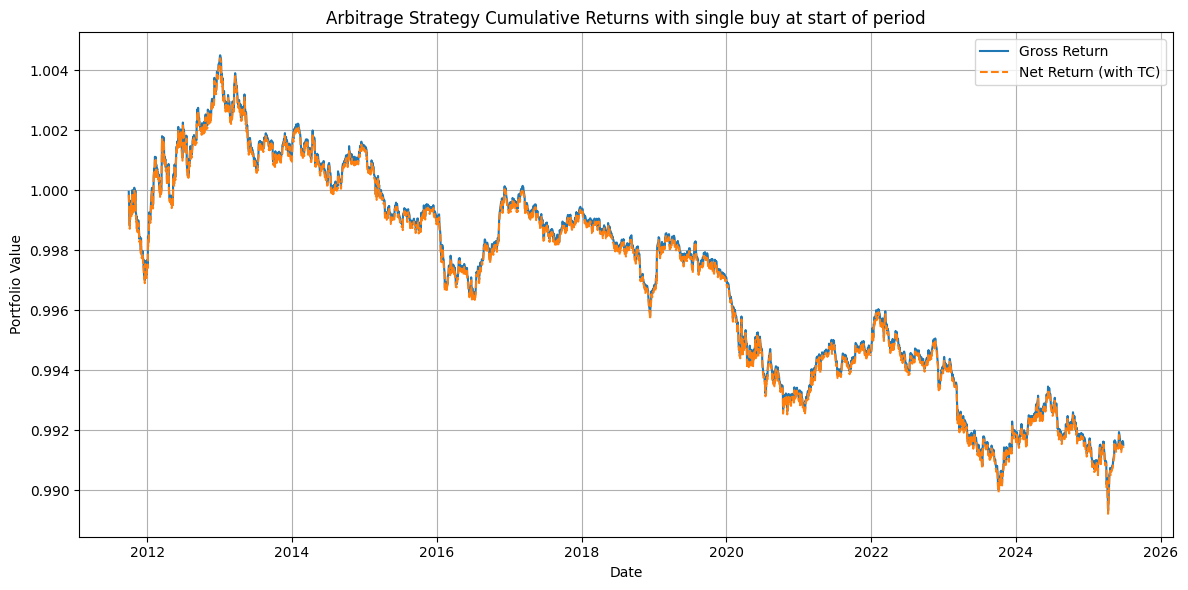

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(gross_return, label='Gross Return')
plt.plot(net_cum_return, label='Net Return (with TC)', linestyle='--')
plt.title("Arbitrage Strategy Cumulative Returns with single buy at start of period")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

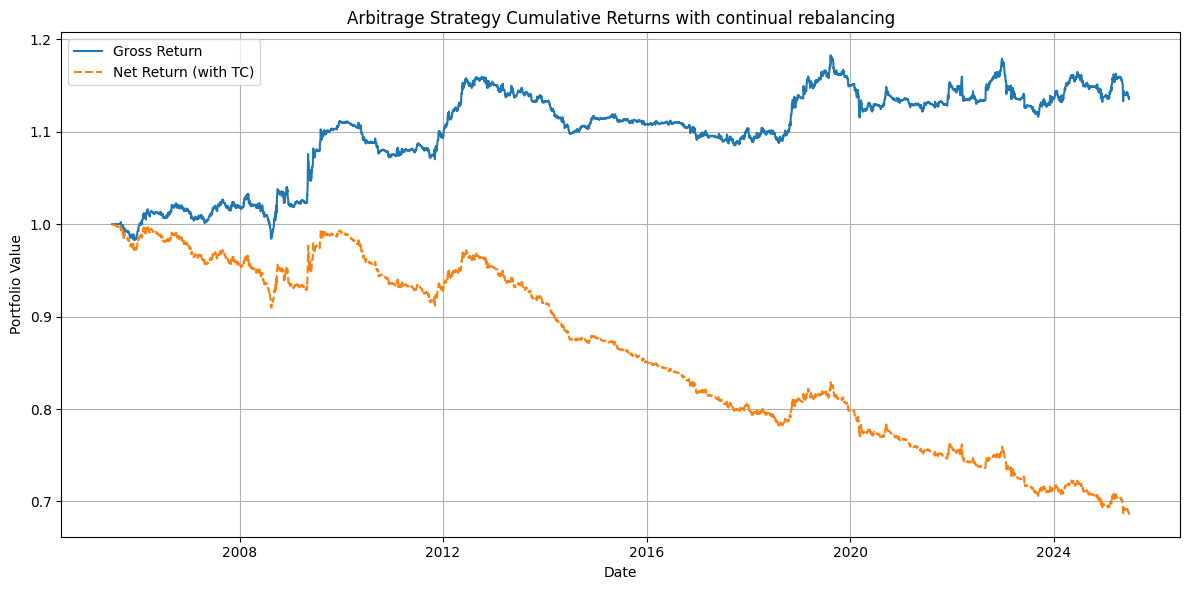

In [68]:
# If we want to rebalance continuously
TRANSACTION_COST = 0.0001  # 0.01% per trade, may be reasonable on large volumes?
DATE = '2011-06-30'
signal = z_sector_adj[filtered_tickers].shift(1)
signal = signal.reindex(close_prices.index).ffill()

returns = close_prices[filtered_tickers].pct_change().loc[signal.index] # net, i.e. 0.xx
daily_return = (signal * returns).mean(axis=1)
gross_return = (1 + daily_return).cumprod()
net_return = daily_return - TRANSACTION_COST
net_cum_return = (1 + net_return).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(gross_return, label='Gross Return')
plt.plot(net_cum_return, label='Net Return (with TC)', linestyle='--')
plt.title("Arbitrage Strategy Cumulative Returns with continual rebalancing")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- For the tech sector alone a BTM-based strategy seemed to work very badly (even worse with rebalancing)! Diversifying among sector while ensuring sector neutrality of the signal improves the results.
- We can also see that the FCFY-based strategy performs better than the BTM one, at least if we do not consider the transaction cost.

One-time portfolio build:  AAPL    -0.031321
ABBV     0.011860
AEO      0.030328
AI       0.016895
AMZN    -0.041775
AVGO    -0.000192
BAC      0.125488
BUD     -0.002958
COST     0.030328
CSCO     0.016895
CVX      0.019551
GE       0.107308
GOOG    -0.023881
GOOGL   -0.024079
GTLB     0.016895
HD       0.030328
JNJ     -0.004280
JPM      0.008155
KO      -0.036969
LLY     -0.007580
MA      -0.032301
META     0.016895
MSFT    -0.022086
NFLX    -0.049620
NVDA    -0.000192
ORCL     0.016895
PG      -0.005147
PLTR     0.016895
TSLA    -0.066997
UNH     -0.133643
V        0.002383
WMT      0.030328
XOM     -0.019551
Name: 2011-06-30 00:00:00, dtype: float64


<Axes: title={'center': 'Average Portfolio Exposure'}, xlabel='Date'>

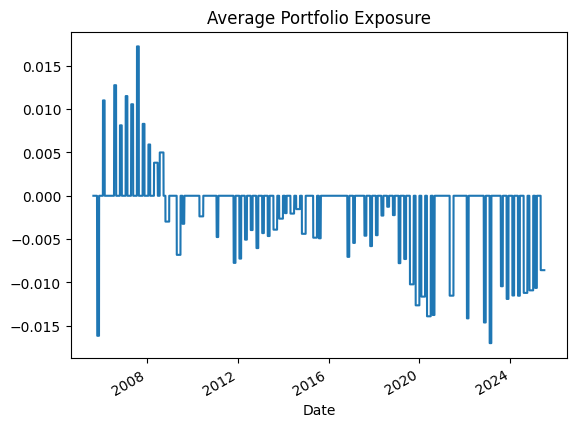

In [16]:
print("One-time portfolio build: ", initial_signal)

signal.mean(axis=1).plot(title="Average Portfolio Exposure")

Next, we will try and
- combine Free Cash Flow Yield and BTM in a unique signal
- include more complex features of fundamentals in the signal, including with ML approaches
- try price regression on fundamentals rather than raw signal